<a href="https://colab.research.google.com/github/danglive/prediction-energy-consumption/blob/master/Prediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
# load dataset
url = 'https://raw.githubusercontent.com/danglive/prediction-energy-consumption/master/EnergyConsumptionEstimation.csv'
dataset = pd.read_csv(url, error_bad_lines=False, parse_dates=True, index_col='timestamp')

In [136]:
# Info of dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4407 entries, timestamp to 2018-05-25 12:00:00
Data columns (total 5 columns):
Delivered_Energy          4407 non-null object
Travelled_Distance        4407 non-null object
Temperature_Exterieure    4407 non-null object
DriverBehaviour           4407 non-null object
DriverSex                 4407 non-null object
dtypes: object(5)
memory usage: 206.6+ KB


In [137]:
# Drop line 1 
dataset = dataset.iloc[1:]
dataset.head(5)

,Delivered_Energy,Travelled_Distance,Temperature_Exterieure,DriverBehaviour,DriverSex
timestamp,,,,,
2017-11-22 23:00:00,9.05700081620839,8.738133146835025e-06,11.3,0.2171607905520091,female
2017-11-23 00:00:00,9.05700081620839,0.0,11.2,0.24535736823806864,male
2017-11-23 01:00:00,9.05700081620839,8.738133146835025e-06,10.8,0.06334444369720382,female
2017-11-23 02:00:00,9.05700081620839,0.0,11.3,0.9304906366876564,male
2017-11-23 03:00:00,9.05700081620839,8.738133146835025e-06,11.7,0.032536781573978324,male


In [138]:
# Selecting the feature
feature = ['Delivered_Energy','Travelled_Distance','DriverBehaviour','DriverSex']
dataset = dataset[feature]
dataset.head(4)

,Delivered_Energy,Travelled_Distance,DriverBehaviour,DriverSex
timestamp,,,,
2017-11-22 23:00:00,9.05700081620839,8.738133146835025e-06,0.2171607905520091,female
2017-11-23 00:00:00,9.05700081620839,0.0,0.24535736823806864,male
2017-11-23 01:00:00,9.05700081620839,8.738133146835025e-06,0.06334444369720382,female
2017-11-23 02:00:00,9.05700081620839,0.0,0.9304906366876564,male


In [0]:
# Import the libraries
from matplotlib import pyplot as plt
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from pandas import concat
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense, Embedding
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error

In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [0]:
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,3] = encoder.fit_transform(values[:,3])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [142]:
scaled.shape, reframed.shape

((4406, 4), (4405, 8))

In [143]:
reframed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
1,0.347495,4.382665e-07,0.217037,0.0,0.347495,0.000000e+00,0.245243,1.0
2,0.347495,0.000000e+00,0.245243,1.0,0.347495,4.382665e-07,0.063169,0.0
3,0.347495,4.382665e-07,0.063169,0.0,0.347495,0.000000e+00,0.930607,1.0
4,0.347495,0.000000e+00,0.930607,1.0,0.347495,4.382665e-07,0.032351,1.0
5,0.347495,4.382665e-07,0.032351,1.0,0.347495,0.000000e+00,0.286251,1.0


In [144]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)     var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1   0.347495  4.382665e-07   0.217037        0.0  0.347495
2   0.347495  0.000000e+00   0.245243        1.0  0.347495
3   0.347495  4.382665e-07   0.063169        0.0  0.347495
4   0.347495  0.000000e+00   0.930607        1.0  0.347495
5   0.347495  4.382665e-07   0.032351        1.0  0.347495


In [145]:
n_sample = reframed.shape[0]
n_sample

4405

In [146]:
# split into train and test sets
values = reframed.values
# Using 60% for train and 40% for test
n_train_hours = int(n_sample*0.6)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2643, 1, 4) (2643,) (1762, 1, 4) (1762,)


Train on 2643 samples, validate on 1762 samples
Epoch 1/50
 - 3s - loss: 0.0732 - val_loss: 0.0480
Epoch 2/50
 - 1s - loss: 0.0162 - val_loss: 0.0381
Epoch 3/50
 - 1s - loss: 0.0107 - val_loss: 0.0315
Epoch 4/50
 - 1s - loss: 0.0086 - val_loss: 0.0260
Epoch 5/50
 - 1s - loss: 0.0074 - val_loss: 0.0216
Epoch 6/50
 - 1s - loss: 0.0067 - val_loss: 0.0182
Epoch 7/50
 - 1s - loss: 0.0062 - val_loss: 0.0156
Epoch 8/50
 - 1s - loss: 0.0058 - val_loss: 0.0138
Epoch 9/50
 - 1s - loss: 0.0056 - val_loss: 0.0125
Epoch 10/50
 - 1s - loss: 0.0054 - val_loss: 0.0116
Epoch 11/50
 - 1s - loss: 0.0053 - val_loss: 0.0110
Epoch 12/50
 - 1s - loss: 0.0052 - val_loss: 0.0106
Epoch 13/50
 - 1s - loss: 0.0051 - val_loss: 0.0103
Epoch 14/50
 - 1s - loss: 0.0051 - val_loss: 0.0101
Epoch 15/50
 - 1s - loss: 0.0050 - val_loss: 0.0099
Epoch 16/50
 - 1s - loss: 0.0050 - val_loss: 0.0097
Epoch 17/50
 - 1s - loss: 0.0050 - val_loss: 0.0095
Epoch 18/50
 - 1s - loss: 0.0049 - val_loss: 0.0094
Epoch 19/50
 - 1s - loss:

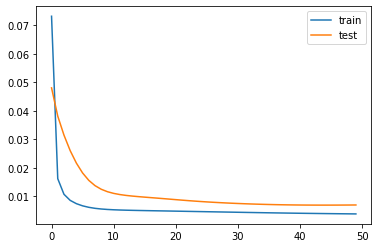

In [147]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [0]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [149]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.176


We can see that the model achieves a respectable RMSE of 2.176, which is lower than an RMSE of 2.2869 found with a Random Forest model.

In [0]:
# Define training time and tesing time
timestamp = dataset.index
timestamp_train = timestamp[:n_train_hours]
timestamp_test = timestamp[1+n_train_hours:]
# creating a dataframe with the combination of both predictions, and appending the right datetimeindex
Random_Pred = pd.DataFrame({'Delivered Energy':  inv_y, 'Prediction': inv_yhat}, index=timestamp_test)

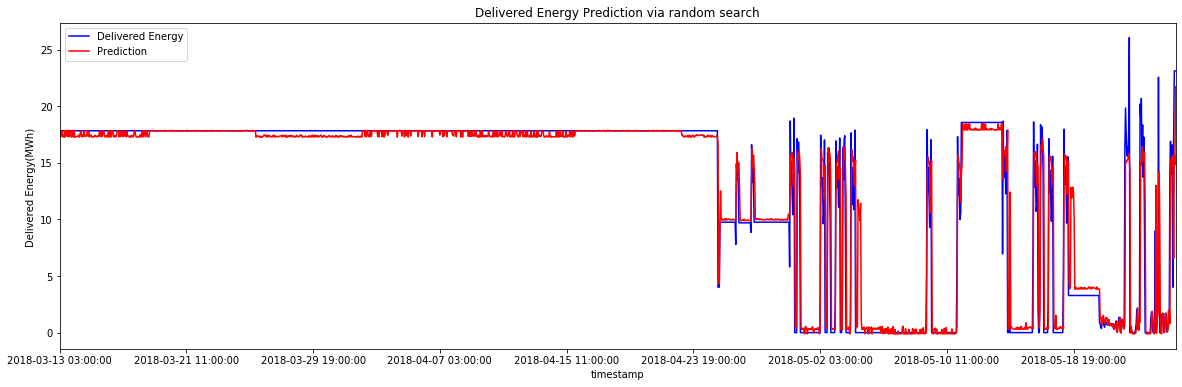

In [153]:
# Visualize
import matplotlib.pylab as plt
Random_Pred.plot(figsize=(20, 6), color=('b', 'r'))
plt.ylabel('Delivered Energy(MWh) ')
plt.title('Delivered Energy Prediction via random search')
plt.show()

In [151]:
# Checking the accuracy of model prediction using grid search
import numpy as np
mape = 100 * np.mean(abs(inv_y - inv_yhat))/np.mean(abs(inv_y))
accuracy = 100 - mape
print('Accuracy = {:0.2f}%.'.format(accuracy))

Accuracy = 94.10%.


**Discussion**

+ Using LSTM improves the precision a bit more than the Random Forest with hyperparameter tuning in the Delivered Energy prediction.

+ Can apply some algorithm for hyperparameter tunning of LSTM model to improve the accuracy.

